# Decision Tree

In [68]:
from pandas import DataFrame
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score, \
    confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


def drop_empty_items(data_frame: DataFrame) -> DataFrame:
    data_frame = data_frame.drop(['Insulin'], axis=1)
    return data_frame[(data_frame['Glucose'] != 0) & (data_frame['BloodPressure'] != 0) & (data_frame['BMI'] != 0)]


def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test


def print_score(y_test, y_pred) -> None:
    # Calculate other evaluation metrics for test set
    print(f"SIMPLE DECISION TREE")
    print("===========================================================================")
    print("\nClassification Report:\n",
          classification_report(y_test, y_pred, target_names=['non-diabetic', 'diabetic']))
    print("Decision Tree Model Evaluation:")

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Accuracy: ", accuracy)
    print(f"Precision (Weighted): {precision:.6f}")
    print(f"Recall (Weighted): {recall:.6f}")
    print(f"F1-Score (Weighted): {f1:.6f}")

    print("Class distribution before SMOTE:", y_train.value_counts().to_dict())
    print("Class distribution after SMOTE:", pd.Series(y_train_smote).value_counts().to_dict())

    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"ROC-AUC: {roc_auc:.6f}")

    # Print confusion matrix with class labels
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_names = ['non-diabetic', 'diabetic']
    print("\nConfusion Matrix with Class Labels:")
    print(pd.DataFrame(conf_matrix, index=class_names, columns=class_names))

    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    print("Specificity: ", specificity)
    sensitivity = tp / (tp + fn)
    print("Sensitivity: ", sensitivity)

In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

features = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'SkinThickness', 'DiabetesPedigreeFunction', 'Age']

df = pd.read_csv('data/diabetes.csv')
df = drop_empty_items(df)

# Feature/Output Separation
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Features
X_train, X_test = scale_features(X_train, X_test)

# SMOTE - Artificial Data Creation
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_smote, y_train_smote)

# Print the Best Parameters
best_dt = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

y_pred = best_dt.predict(X_test)
print_score(y_test, y_pred)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5}
SIMPLE DECISION TREE

Classification Report:
               precision    recall  f1-score   support

non-diabetic       0.87      0.76      0.81       102
    diabetic       0.56      0.72      0.63        43

    accuracy                           0.75       145
   macro avg       0.72      0.74      0.72       145
weighted avg       0.78      0.75      0.76       145

Decision Tree Model Evaluation:
Accuracy:  0.7517241379310344
Precision (Weighted): 0.776803
Recall (Weighted): 0.751724
F1-Score (Weighted): 0.759166
Class distribution before SMOTE: {0: 373, 1: 206}
Class distribution after SMOTE: {0: 373, 1: 373}
ROC-AUC: 0.742818

Confusion Matrix with Class Labels:
              non-diabetic  diabetic
non-diabetic            78        24
diabetic                12        31
Specificity:  0.7647058823529411
Sensitivity:  0.7209302325581395


# Feature Importance Analysis

In [74]:
import pandas as pd
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_dt.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:\n", feature_importance)


Feature Importance:
                     Feature  Importance
1                   Glucose    0.432226
6                       Age    0.185580
4             SkinThickness    0.123446
3                       BMI    0.081095
5  DiabetesPedigreeFunction    0.075116
2             BloodPressure    0.052448
0               Pregnancies    0.050089


# Visualization of Tree

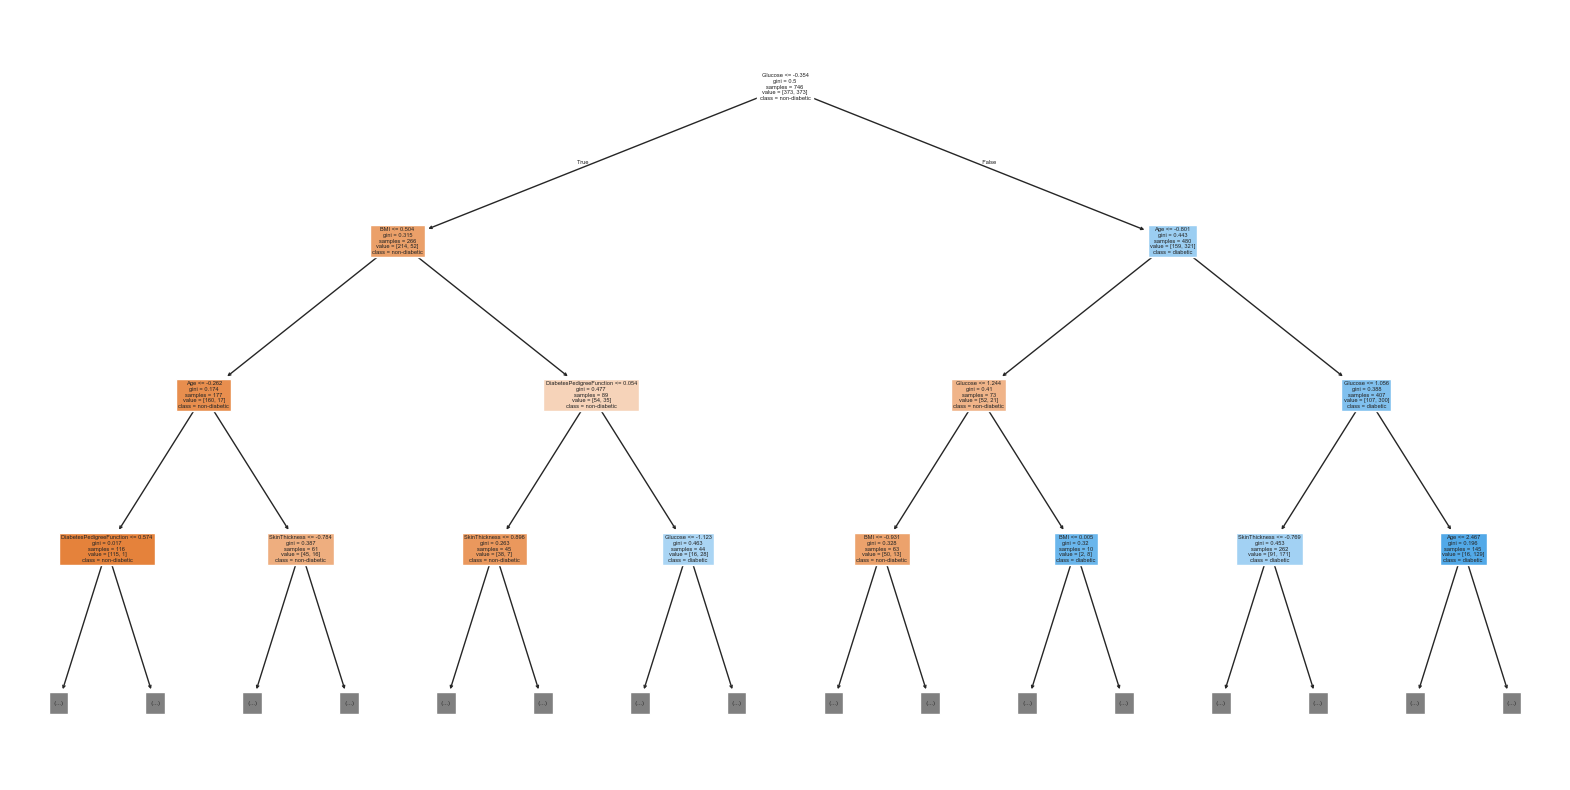

In [32]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plot_tree(best_dt, feature_names=features, class_names=['non-diabetic', 'diabetic'], filled=True,max_depth=3)
plt.show()

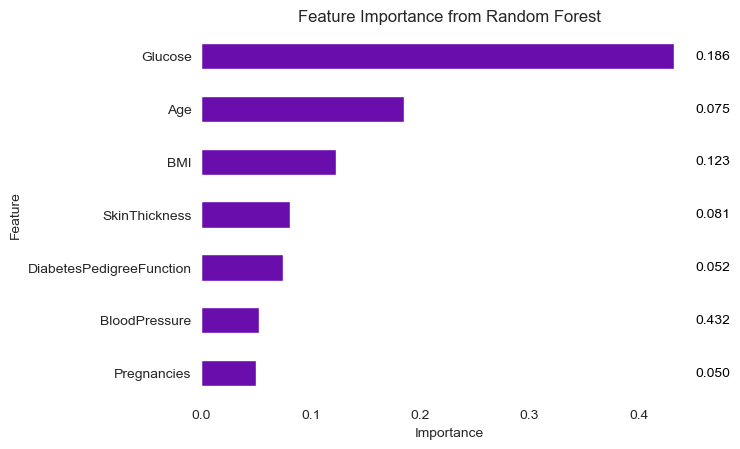

<Figure size 640x480 with 0 Axes>

In [67]:
feature_importance = pd.Series(best_dt.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=True).plot(kind='barh', color='#6A0DAD') #'#4B0082', '#6A0DAD'
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
ax = plt.gca()
ax.set_facecolor('none')

# Find the maximum importance value to set a consistent label position
max_importance = feature_importance.max()
label_position = max_importance + 0.02  # Fixed position slightly beyond the longest bar
for index, value in enumerate(feature_importance):
    plt.text(label_position, index, f'{value:.3f}', va='center', ha='left', color='black', fontsize=10)

plt.show()
plt.gcf().set_facecolor('none')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

plt.show()
plt.close()
